In [211]:
# All the imports you will need in the whole lab
from skimage import io
from skimage.filters import median
import skimage.exposure as exposure
from scipy.signal import gaussian, convolve2d
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, skeletonize, thin
from skimage.color import rgb2gray, rgb2hsv, rgb2yuv, rgb2ycbcr
from skimage.measure import find_contours
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.feature import hog
import os
import numpy as np
from commonfunctions import *
import matplotlib.pyplot as plt
from scipy.spatial import distance
from skimage.util import img_as_float
from scipy.spatial.distance import squareform, pdist, cdist



In [212]:
def skin_mask_ycrcb(img):
    #get yCrCb components of the image
    ycc = rgb2ycbcr(img)
    y, cr, cb = ycc[:,:,0], ycc[:,:,1], ycc[:,:,2]
    
    b1, b2, b3, b4, b5 = 0, 0 ,0, 0, 0
    b1 = 1.5862 * cb + 20
    b2 = 0.3448 * cb + 76.2069
    b3 = -1.005 * cb + 234.5652
    b4 = -1.15 * cb + 301.75
    b5 = -2.2857 * cb + 432.85
    boundries = [b1, b2, b3, b4, b5]
    ycrcb_rule = np.logical_and.reduce([
        b1 - cr >= 0,
        b2 - cr <= 0,
        b3 - cr <= 0,
        b4 - cr >= 0,
        b5 - cr >= 0,
    ])
    return ycrcb_rule


In [213]:
def skin_mask_rgb(img):
    red_channel = img[:,:,0]
    green_channel = img[:,:,1]
    blue_channel = img[:,:,2]
    rgb_max = np.maximum(np.maximum(red_channel, green_channel), blue_channel)
    rgb_min = np.minimum(np.minimum(red_channel, green_channel), blue_channel)
    rgb_rule_1 = np.logical_and.reduce([
        red_channel > 95, green_channel > 60, blue_channel > 60,
        rgb_max - rgb_min > 15, abs(red_channel - green_channel) > 15, red_channel > green_channel, red_channel > blue_channel
    ])
    
    rgb_rule_2 = np.logical_and.reduce([
        red_channel > 220 , green_channel > 210 , blue_channel > 170,
        abs(red_channel - green_channel) > 15, red_channel > blue_channel, green_channel > blue_channel
    ])
    return np.logical_or(rgb_rule_1, rgb_rule_2)

In [214]:
def skin_mask_hsv(img):
    hsv = rgb2hsv(img)*255
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    hsv_rule = np.logical_or(h < 60, h > 200)
    return hsv_rule

In [215]:
def adaptive_thresholding(img):
    hist = exposure.histogram(img, nbins=256)
    total_num_of_pixels = img.shape[0]*img.shape[1]
    initial_threshold = round(sum(hist[1]*hist[0])/total_num_of_pixels)
    grey_level_count = hist[1][-1]
    while True:
        list_of_lower_values = hist[1][hist[1] < initial_threshold]
        frequency_of_lower_values = hist[0][hist[1] < initial_threshold]
        lower_threshold = round(sum(list_of_lower_values*frequency_of_lower_values)/sum(frequency_of_lower_values))

        list_of_higher_values = hist[1][hist[1] >= initial_threshold]
        frequency_of_higher_values = hist[0][hist[1] >= initial_threshold]
        upper_threshold = round(sum(list_of_higher_values*frequency_of_higher_values)/sum(frequency_of_higher_values))
        new_threshold = round((lower_threshold + upper_threshold)/2)
        
        if new_threshold == initial_threshold:
            break
        else:
            initial_threshold = new_threshold
    return new_threshold

In [216]:
def get_hand_contours(hand_img):
    #get the center of the hand
    hand_img = hand_img.astype(np.uint8)
    contours = find_contours(hand_img, 0.8, fully_connected='high')
    contouring_threshold = 0
    # get contoring threshold by finding the average length of the longest 3 contours
    contouring_threshold = np.mean(sorted([len(c) for c in contours])[-3:])
    contours_saved = []
    for c in contours:
    #draw the contour if it is not too small
        if c.shape[0] > contouring_threshold: 
            #plt.plot(c[:, 1], c[:, 0], linewidth=2)
            contours_saved.append(c)
    return contours_saved


In [217]:
def normalize_img(img):
    #resize photo so that only the hand is visible
    # get the most left pixel that is not black
    most_left = np.where(img.sum(axis=0) != 0)[0][0]
    most_top = np.where(img.sum(axis=1) != 0)[0][0]
    most_right = np.where(img.sum(axis=0) != 0)[0][-1]
    most_bottom = np.where(img.sum(axis=1) != 0)[0][-1]
    resized_img = img[most_top:most_bottom, most_left-10:most_right+10]
    return resized_img

In [218]:
def combined_hsv_detection(img):
    min_h = 0
    max_h = 56.8183

    min_s = 0.0
    max_s = 0.2681

    min_v = 0.3647
    max_v = 0.78431
    img_hsv = rgb2hsv(img)
    h2 = img_hsv[:,:,0]
    s2 = img_hsv[:,:,1]
    v2 = img_hsv[:,:,2]
    h2 = np.rad2deg(h2)
    thresh_h = (h2 > min_h) & (h2 < max_h)
    thresh_s = (s2 > min_s) & (s2 < max_s)
    thresh_v = (v2 > min_v) & (v2 < max_v)
    result = thresh_h & thresh_s & thresh_v
    return result

In [219]:
def is_bright(img):
    img = rgb2hsv(img)
    v = img[:,:,2]
    v = v*255
    thresh = adaptive_thresholding(v)
    s1 = np.sum(v[v >= thresh])
    s2 = np.sum(v[v < thresh])
    if s1 > s2:
        return True
    else:
        return False

In [220]:
def feature_extraction(img):
    #feature is a 25x25 matrix each cell is the output birghtness of a 5x5 pixel in the image
    b = np.zeros((42,42))
    #we get the brightness of each cell by taking the average of the brightness of the pixels in the cell
    for i in range(0,42):
        for j in range(0,42):
            b[i,j] = np.sum(img[i*3:(i+1)*3,j*3:(j+1)*3])
    # print(b)
    #show_images([b], ['feature'])
    return b

In [221]:
def compare_feature(b1, b2):
    #compare the feature of two images
    #if the two feature are black we consider them the same
    #if the two feature are white have the same brightness we consider them the same
    #if the two feature are white but have different brightness whithin a certain threshold we consider them the same
    print(np.max(b1), np.min(b1))
    print(np.max(b2), np.min(b2))
    matches = 0
    for i in range(0,42):
        for j in range(0,42):
            if (b1[i,j] == 0 and b2[i,j] == 0):
                matches = matches + 1
            # elif (b1[i,j] == b2[i,j]):
            #     matches = matches + 1
            elif (b1[i,j] > 0.2 and b2[i,j] > 0.2):
                matches = matches + 1
    print (matches)
    print (matches/(42*42))

In [222]:
def get_difference(hog1,hog2):
    dst = distance.cosine(hog1, hog2)
    print(1-dst)

In [223]:
def resize_img(img1):
    #resize photo to 200x200
    img_new = resize(img1, (128, 128), anti_aliasing=False)
    return img_new

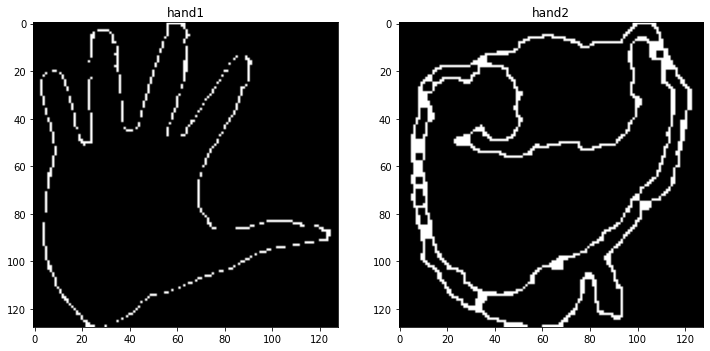

6.0 0.0
9.0 0.0
1229
0.6967120181405896


C:\Users\Fastora\AppData\Local\Temp\ipykernel_8116\4100664651.py:60: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(result1, orientations=8, pixels_per_cell=(16, 16),


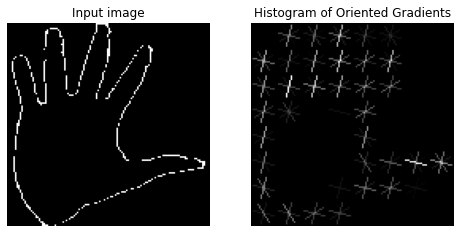

C:\Users\Fastora\AppData\Local\Temp\ipykernel_8116\4100664651.py:75: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd2, hog_image2 = hog(result2, orientations=8, pixels_per_cell=(16, 16),


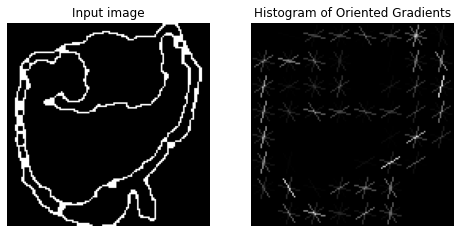

0.593584298060543


In [229]:
img = io.imread('images/hand2.jpg')
img2 = io.imread('images/hand4.jpg')

if (is_bright(img)):
    hand = skin_mask_rgb(img)
    #show_images([hand], ['hand'])
    c = get_hand_contours(hand)
    hand1_contoured = np.zeros((img.shape[0],img.shape[1]))
else:
    hand = combined_hsv_detection(img)
    for i in range(0, 10):
        hand = median(hand)
    #show_images([canny(hand)], ['hand'])
    c = get_hand_contours(hand)
    hand1_contoured = np.zeros((img.shape[0],img.shape[1]))
for contour in c:
    for point in contour.astype(int):
        hand1_contoured[point[0], point[1]] = 1
        
h1_norm = normalize_img(hand1_contoured)  

if (is_bright(img2)):
    hand = skin_mask_rgb(img2)
    #show_images([hand], ['hand'])
    c1 = get_hand_contours(hand)
    hand2_contoured = np.zeros((img2.shape[0],img2.shape[1]))
else:
    hand = combined_hsv_detection(img2)
    for i in range(0, 10):
        hand = median(hand)
    #show_images([canny(hand)], ['hand'])
    c1 = get_hand_contours(hand)
    hand2_contoured = np.zeros((img2.shape[0],img2.shape[1]))
for contour in c1:
    for point in contour.astype(int):
        hand2_contoured[point[0], point[1]] = 1  
h2_norm = normalize_img(hand2_contoured)

result1 = resize_img(h1_norm)
result2 = resize_img(h2_norm)

se = np.ones((3,3))
result1 = binary_closing(result1, se)
result2 = binary_closing(result2, se)
show_images([result1, result2], ['hand1', 'hand2'])

b1 = feature_extraction(result1)
b2 = feature_extraction(result2)
compare_feature(b1, b2)

fd, hog_image = hog(result1, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(result1, cmap=plt.cm.gray)
ax1.set_title('Input image')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

fd2, hog_image2 = hog(result2, orientations=8, pixels_per_cell=(16, 16),
                      cells_per_block=(1, 1), visualize=True, multichannel=False)
fig2 , (ax3, ax4) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax3.axis('off')
ax3.imshow(result2, cmap=plt.cm.gray)
ax3.set_title('Input image')
 
hog2_image_rescaled = exposure.rescale_intensity(hog_image2, in_range=(0, 10))
ax4.axis('off')
ax4.imshow(hog2_image_rescaled, cmap=plt.cm.gray)
ax4.set_title('Histogram of Oriented Gradients')
plt.show()
get_difference(fd, fd2)



In [225]:
def kmeans(features, k, num_iters=100):
    """ Use kmeans algorithm to group features into k clusters.

    Args:
        features - Array of N features vectors. Each row represents a feature
            vector.
        k - Number of clusters to form.
        num_iters - Maximum number of iterations the algorithm will run.

    Returns:
        assignments - Array representing cluster assignment of each point.
            (e.g. i-th point is assigned to cluster assignments[i])
    """

    N, D = features.shape

    assert N >= k, 'Number of clusters cannot be greater than number of points'

    # Randomly initalize cluster centers
    idxs = np.random.choice(N, size=k, replace=False)
    centers = features[idxs]
    assignments = np.zeros(N, dtype=np.uint32)
    prev_assignments = np.zeros(N, dtype=np.uint32)
    

    for n in range(num_iters):
        # Assign each point to the closest center
        for i, feature in enumerate(features):
            min_distance = float('inf')
            min_idx = None
            for j, center in enumerate(centers):
                distance = np.linalg.norm(feature - center)
                if distance < min_distance:
                    min_distance = distance
                    min_idx = j
            assignments[i] = min_idx

        # Compute new center of each cluster
    for i in range(k):
            cluster_features = features[assignments == i]
            if cluster_features.size > 0:
                centers[i] = np.mean(cluster_features, axis=0)
            else:
                # If the cluster is empty, randomly re-initialize the center
                idx = np.random.randint(N)
                centers[i] = features[idx]
          # Stop if cluster assignments did not change
            if np.array_equal(assignments, prev_assignments):
                    break
            prev_assignments = assignments

    return assignments 

In [226]:
def kmeans_fast(features, k, num_iters=100):
    """ Use kmeans algorithm to group features into k clusters.

    This function makes use of numpy functions and broadcasting to speed up the
    first part(cluster assignment) of kmeans algorithm.

    Hints
    - You may find cdist (imported from scipy.spatial.distance) and np.argmin useful

    Args:
        features - Array of N features vectors. Each row represents a feature
            vector.
        k - Number of clusters to form.
        num_iters - Maximum number of iterations the algorithm will run.

    Returns:
        assignments - Array representing cluster assignment of each point.
            (e.g. i-th point is assigned to cluster assignments[i])
    """

    N, D = features.shape

    assert N >= k, 'Number of clusters cannot be greater than number of points'

    # Randomly initalize cluster centers
    idxs = np.random.choice(N, size=k, replace=False)
    centers = features[idxs]
    assignments = np.zeros(N, dtype=np.uint32)

    for n in range(num_iters):
        # Assign each point to the closest center
      distances = cdist(features, centers)
      assignments = np.argmin(distances, axis=1)

    # Compute new center of each cluster
      new_centers = np.zeros((k, D))
    for i in range(k):
        cluster_points = features[assignments == i]
        new_centers[i] = np.mean(cluster_points, axis=0)

    # Check for convergence
        if np.allclose(centers, new_centers):
              break

    centers = new_centers

    return assignments

In [227]:

def color_features(img):
    """ Represents a pixel by its color.

    Args:
        img - array of shape (H, W, C)

    Returns:
        features - array of (H * W, C)
    """
    imgArr=np.array(img)
    H, W, C = imgArr.shape
    imgArr = img_as_float(imgArr)
    features = np.zeros((H*W, C))

    for i in range(H):
        for j in range(W):
            features[i*W + j] = imgArr[i, j]

    return features



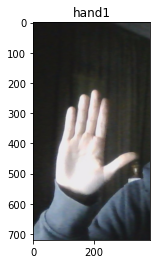

[[0.10196078 0.08627451 0.08235294]
 [0.10196078 0.08627451 0.08235294]
 [0.10196078 0.08627451 0.08235294]
 ...
 [0.10588235 0.08627451 0.10196078]
 [0.10196078 0.08627451 0.09019608]
 [0.10196078 0.08627451 0.09019608]]


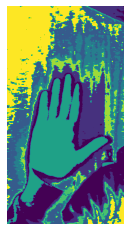

In [228]:
img_rgb = io.imread('images/hand1.jpg')
show_images([img_rgb], ['hand1'])
features = color_features(img_rgb)
print(features)

assignments = kmeans_fast(features, 8)
segments = assignments.reshape((img_rgb.shape[0], img_rgb.shape[1]))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()